# Computed Tomography Pre-processing Tutorial

## Motivation
After decades of research, cancer still remains as a nightmare for human beings. One particular source of lethality among various types of cancer stems from the fact that they are hard to diagnose at a early stage. In fact, biomecial researchers have pointed out that although cancer cells are extremely hard to be completely eradicated, they could be controlled at a peaceful level given appropriate treatments during the early stage. Therefore, one of the current trends in cancer research targets at setting an effective early-stage warning mechanism.

However, detecting early-stage cancer is a needle-in-a-haystack task, and can consume huge amount of time for medical professionals to reach their conclusions. Our question is, can computer assist human professionals to recognize cancerous patterns among large volumes of medical data, and perform quick diagnosis?

## Introduction
In this notebook, we will introduce libraries and tools to handle data generated from medical instrumentation. Specifically, we will focus on X-ray Computed Tomography (CT) imaging. CT can be viewed as taking X-ray "slices" along certain direction in order to capture 3D spatial information of human tissue. A typical CT scan will contain several DCM files, an industry-standard file format to store 2D information for each "slice". 


## Unfold a DCM file
We will use `pydicom` as the primary python library to interact with CT data. A comprehensive introduction of the library can be found at https://github.com/pydicom/pydicom. To install the package, you can either execute
```shell
pip install pydicom
```
or if you are running an anaconda environment,
```
conda install -c conda-forge pydicom 
```
Now, we can read in a sample DCM file and see what information it provides us.

In [2]:
import pydicom

sample = pydicom.read_file("sample.dcm")
print(sample)

(0008, 0005) Specific Character Set              CS: 'ISO_IR 100'
(0008, 0016) SOP Class UID                       UI: CT Image Storage
(0008, 0018) SOP Instance UID                    UI: 1.2.840.113654.2.55.1582830837145501044562724636106343359
(0008, 0060) Modality                            CS: 'CT'
(0008, 103e) Series Description                  LO: 'Axial'
(0010, 0010) Patient's Name                      PN: '00cba091fa4ad62cc3200a657aeb957e'
(0010, 0020) Patient ID                          LO: '00cba091fa4ad62cc3200a657aeb957e'
(0010, 0030) Patient's Birth Date                DA: '19000101'
(0018, 0060) KVP                                 DS: ''
(0020, 000d) Study Instance UID                  UI: 2.25.86208730140539712382771890501772734277950692397709007305473
(0020, 000e) Series Instance UID                 UI: 2.25.11575877329635228925808596800269974740893519451784626046614
(0020, 0011) Series Number                       IS: '3'
(0020, 0012) Acquisition Number              

Not surprisingly, a single CT slice contains plenty of meta-data, some of which are privacy-sensitive and hence needs to be handled with great care. To name a few

In [3]:
print(sample.PatientName, sample.PatientID, sample.PatientBirthDate)

00cba091fa4ad62cc3200a657aeb957e 00cba091fa4ad62cc3200a657aeb957e 19000101


Another way to access data fields inside a DCM file is to utilize the offset at the front of each line. Take `sample.PatientName` as example. 
```
(0010, 0010) Patient's Name                      PN: '00cba091fa4ad62cc3200a657aeb957e'
```
Therefore, we can access the same information via the following line

In [4]:
print(sample[0x10, 0x10].value)

00cba091fa4ad62cc3200a657aeb957e


Generally speaking, accessing fields via their names is preferred over using offsets. If you forget the field names, or simply do not know what fields are available, the following line might be helpful. 

In [5]:
print(sample.dir())

['AcquisitionNumber', 'BitsAllocated', 'BitsStored', 'Columns', 'FrameOfReferenceUID', 'HighBit', 'ImageOrientationPatient', 'ImagePositionPatient', 'InstanceNumber', 'KVP', 'Modality', 'PatientBirthDate', 'PatientID', 'PatientName', 'PatientOrientation', 'PhotometricInterpretation', 'PixelData', 'PixelPaddingValue', 'PixelRepresentation', 'PixelSpacing', 'PositionReferenceIndicator', 'RescaleIntercept', 'RescaleSlope', 'Rows', 'SOPClassUID', 'SOPInstanceUID', 'SamplesPerPixel', 'SeriesDescription', 'SeriesInstanceUID', 'SeriesNumber', 'SliceLocation', 'SpecificCharacterSet', 'StudyInstanceUID', 'WindowCenter', 'WindowWidth']


## Visualize Single CT Slice
For our purpose, we are most interested in the visual content in a DCM file. The pixel information can be extracted via the `pixel_array` property. For instance,

In [6]:
import numpy as np

print(sample.pixel_array)

[[-2000 -2000 -2000 ... -2000 -2000 -2000]
 [-2000 -2000 -2000 ... -2000 -2000 -2000]
 [-2000 -2000 -2000 ... -2000 -2000 -2000]
 ...
 [-2000 -2000 -2000 ... -2000 -2000 -2000]
 [-2000 -2000 -2000 ... -2000 -2000 -2000]
 [-2000 -2000 -2000 ... -2000 -2000 -2000]]


A very natural way to visualize the pixels is to rely on the `matplotlib` library. Let's take a peek at the scan.

In [7]:
import matplotlib.pyplot as plt

plt.imshow(sample.pixel_array, cmap="bone")
plt.show()

<Figure size 640x480 with 1 Axes>

So here is our first visualization of the cross-section of human chest, from a top-down view instead of the front-to-back view that we are used to. The two hollow regions in the middle represent the patient's lung. Later, we would pay specific attention to these regions, thus it would be a good idea to segment out the lung regions based on their pixel intensities. Before we do that, let's get a feeling of the overall intensity distribution.

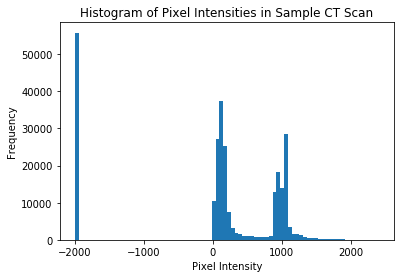

In [8]:
pixels = sample.pixel_array

fig = plt.figure()
ax = fig.add_subplot(111)

ax.hist(pixels.flatten(), bins=80)

ax.set_title("Histogram of Pixel Intensities in Sample CT Scan")
ax.set_xlabel('Pixel Intensity')
ax.set_ylabel('Frequency')

plt.show()

The distribution looks reasonable, excpet for the wired peak on the left. If we take a closer look at the scan visualization, its four corners do not contain visual information, and it turns out that these black regions are marked with pixel value -2000 in `sample.pixel_array`. Therefore, we do not need to worry about them for now.

The valid pixels, however, are in raw form and cannot be utilize before being tranformed into a "standard" form. More specifically, raw pixels are taken directly from medical instruments, and thus the readings contain machine-specific information that needs to be standardized. The normalization is a simple linear transform, specified by the following two parameters in the DCM file.

In [9]:
print(sample.RescaleSlope, sample.RescaleIntercept)

1 -1024


Now the transformation becomes
$$p_{norm} = s\cdot p_{original} + d\qquad s = 1, d = -1024$$
The transformed value are in so-called Hounsfield unit. You can find more information at https://en.wikipedia.org/wiki/Hounsfield_scale. The standardized X-ray image has the following distribution.

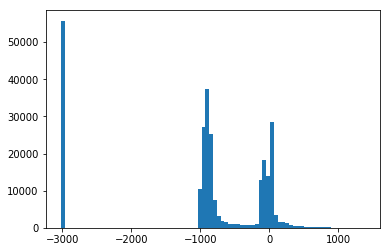

In [10]:
pixels -= 1024
plt.hist(pixels.flatten(), bins=80)
plt.show()

Due to the variation in X-ray absorbance among different substances, we can segment out the lung regions using a thresholding method. In the following snippet, multiple threshold values are experimented.

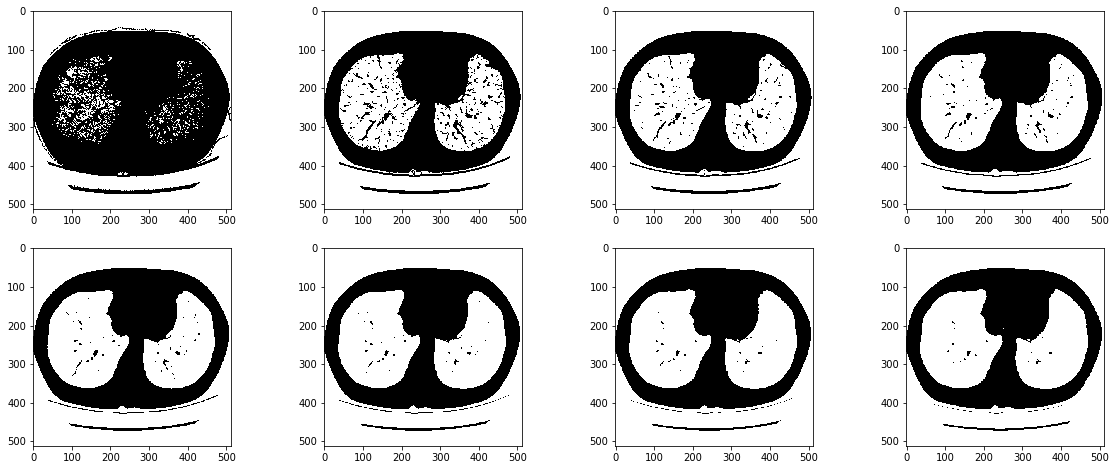

In [11]:
LUNG_THRESH = -900

row = 2
col = 4
fig=plt.figure(figsize=(20,8))

for i in range(row*col):
    mask = sample.pixel_array < LUNG_THRESH + i*100
    fig.add_subplot(row, col, i+1)
    plt.imshow(mask, cmap="bone")
    
plt.show()

The semgentation task is completed through the following steps
1. Apply threshold -400 to the standardized scan.
2. Impose morphological operation.
3. something else...

Now we introduce each step with explanation. Before that, let's import all the libraries that we'll use in a minute.

In [12]:
from skimage import morphology
from skimage import measure

### Initial Threshold
We choose -400 as the threshold for a reason. Physically, the lung is an air bag encompassed by a wall of lung tissue. Air has an Housefield unit around -1000, while lung tissue has its value ranges from -700 to -600. The border of our lungs are therefore defined by pixels with values within this range. 

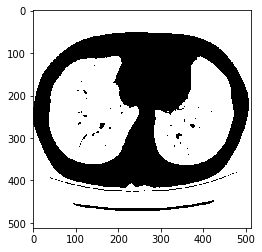

In [13]:
LUNG_THRESH = -400
mask = sample.pixel_array < LUNG_THRESH
plt.imshow(mask, cmap="bone")
plt.show()

### Morphological Operations: Dilation
The mask generated above is very crude and noisy. The centering two white blobs are our regions of interest, but they currently contain a handful of small holes. We can close these holes by an dilation operation, a common image processing technique. 

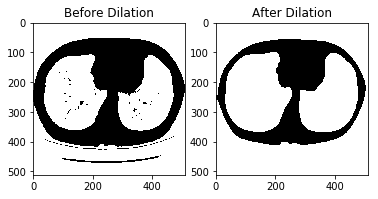

In [14]:
dilation_radius = [12, 12]
mask_dilated = morphology.dilation(mask,np.ones(dilation_radius))

plt.subplot(121)
plt.imshow(mask, cmap="bone")
plt.title("Before Dilation")

plt.subplot(122)
plt.imshow(mask_dilated, cmap="bone")
plt.title("After Dilation")
plt.show()

The dilation operation works a bit like convolution. As a result, the black sprinkles in the center are averaged with their surrounding white area, and thus get "washed" away. Notice that two arcs in the lower part of the original image also vanish after dilation. 

However, ideally we want our mask containing only the blobs in the middle, but now there is a giant mask on the border. Luckily, we can use `skimage.segmentation.clear_border` to get rid of it.

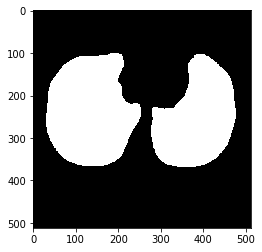

In [15]:
from skimage.segmentation import clear_border

mask_clear = clear_border(mask_dilated)
plt.imshow(mask_clear, cmap="bone")
plt.show()

And the final lung semgmented looks like this

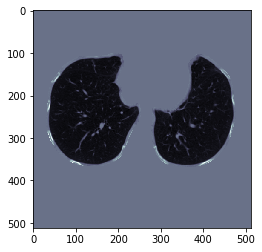

In [16]:
mask = mask_clear
pixels_segmented = sample.pixel_array * mask
plt.imshow(pixels_segmented, cmap="bone")
plt.show()

### Putting it Altogether

In [17]:
import os

def segment_lung(img):
    LUNG_THRESH = -400
    mask = img < LUNG_THRESH
    dilation_radius = [12, 12]
    mask_dilated = morphology.dilation(mask,np.ones(dilation_radius))
    mask_clear = clear_border(mask_dilated)
    mask = mask_clear

    return img * mask

paths = ["sample/" + f for f in os.listdir('sample')]
images = [pydicom.read_file(p) for p in paths]
images.sort(key=lambda x: -x.SliceLocation)

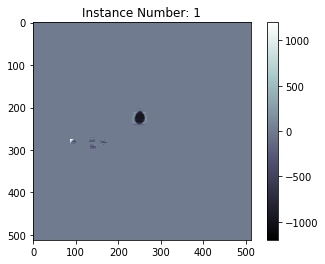

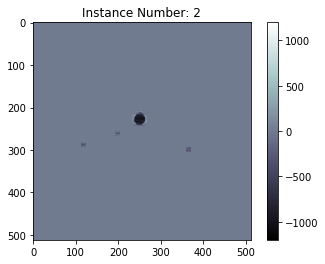

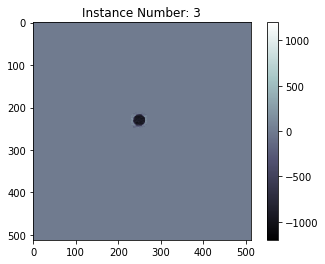

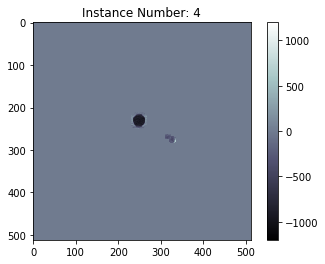

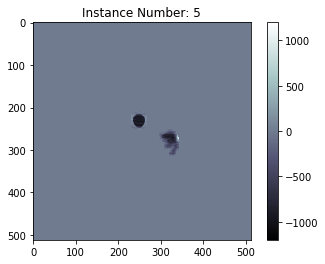

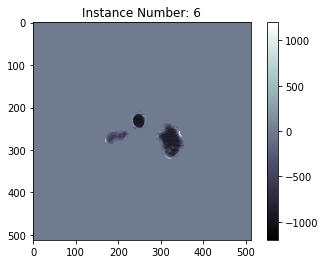

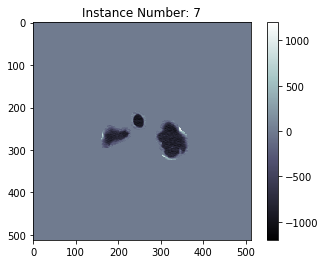

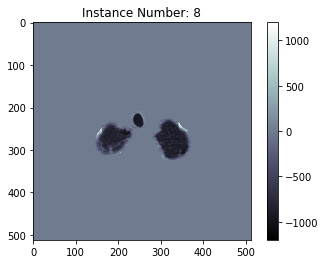

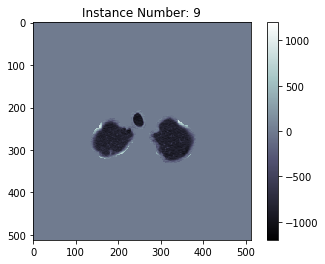

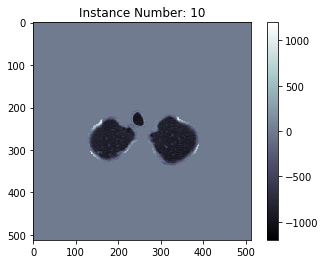

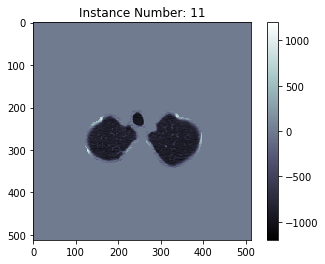

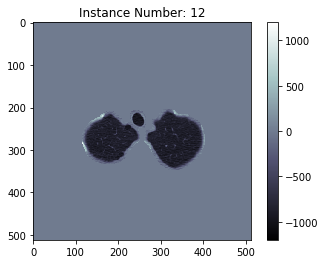

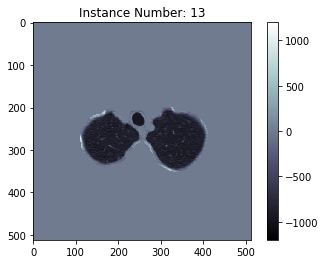

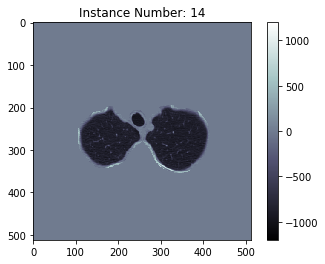

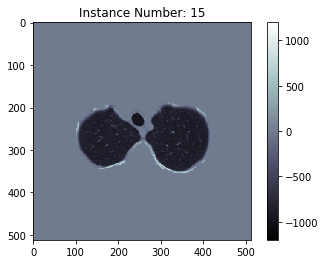

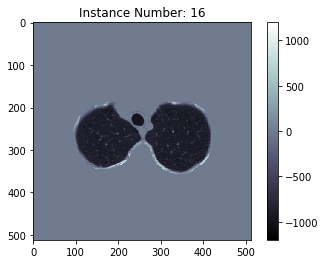

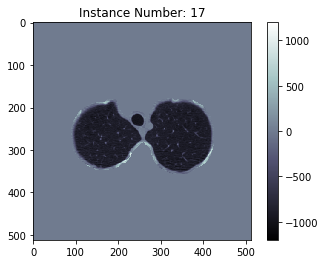

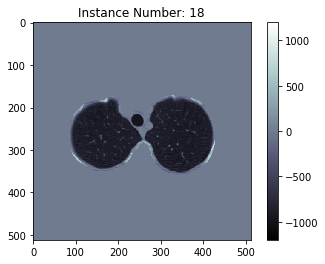

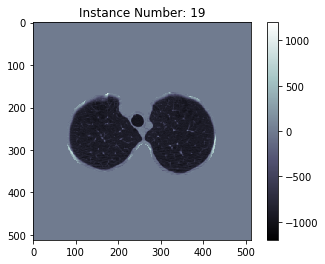

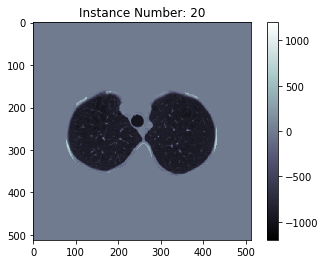

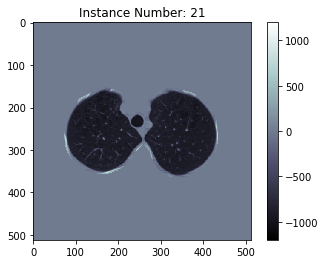

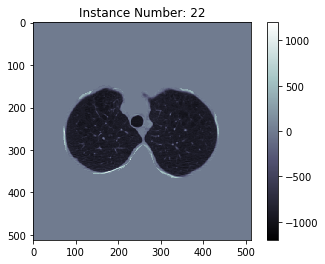

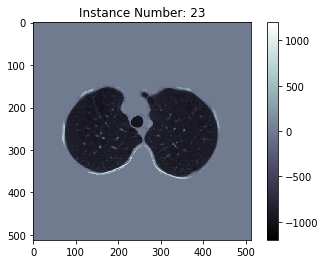

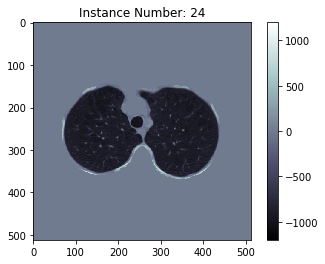

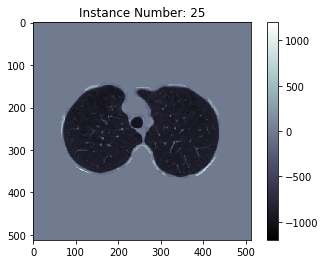

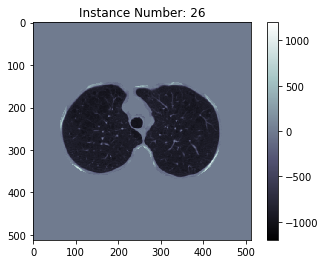

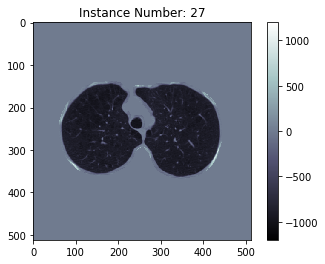

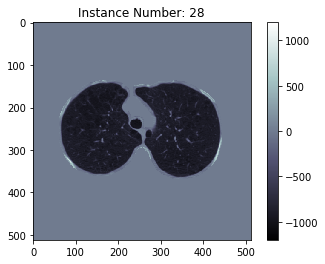

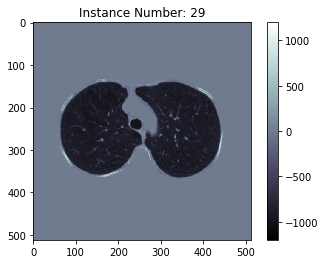

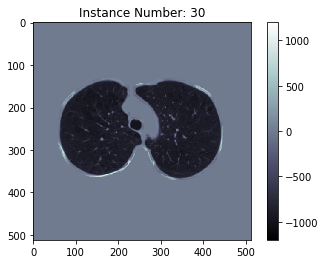

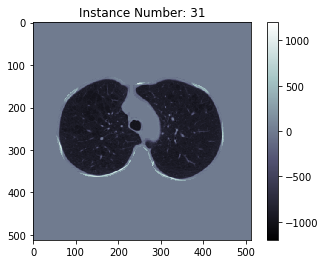

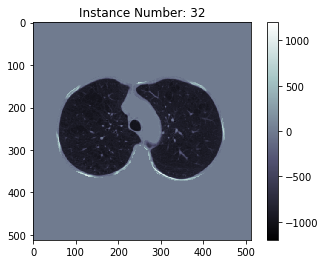

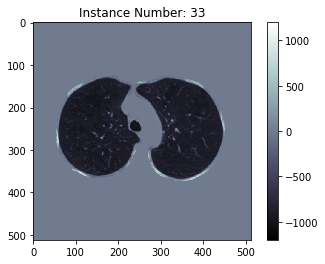

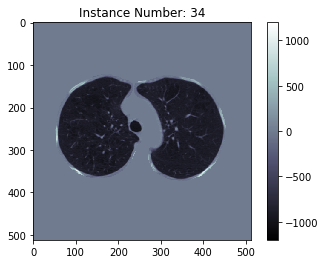

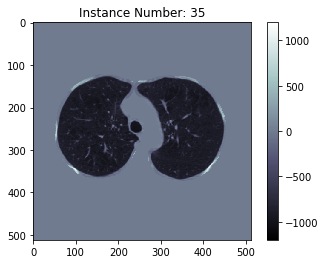

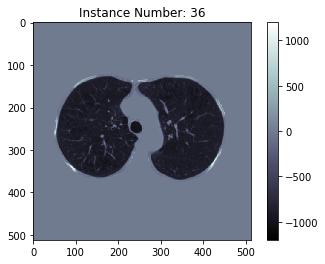

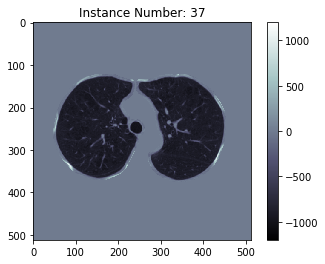

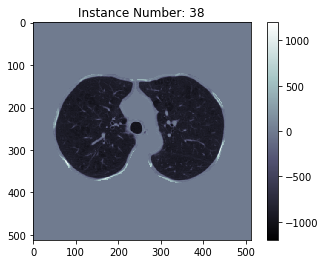

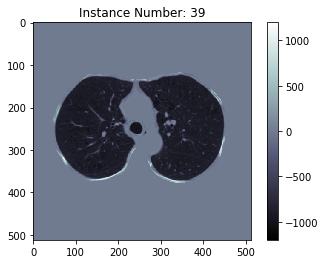

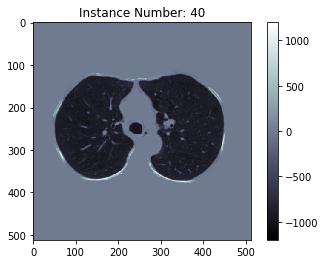

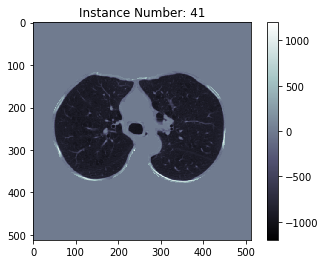

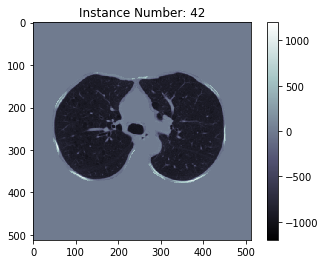

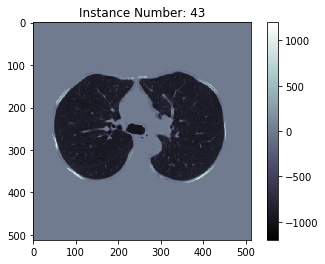

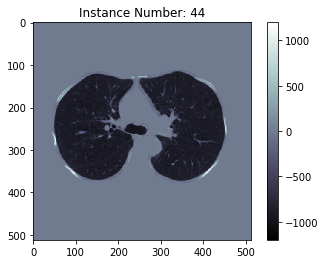

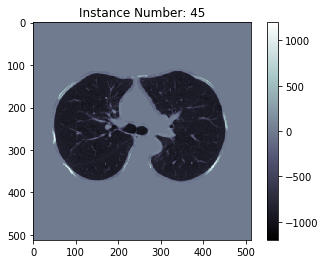

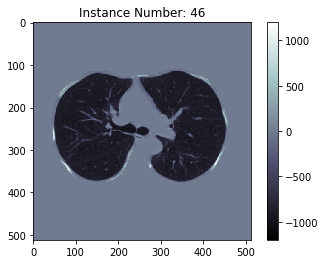

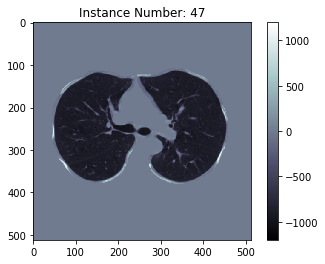

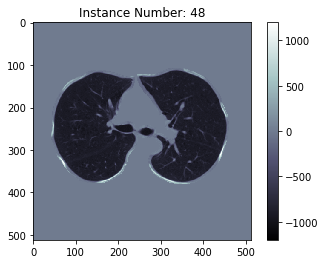

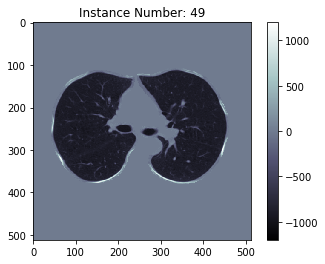

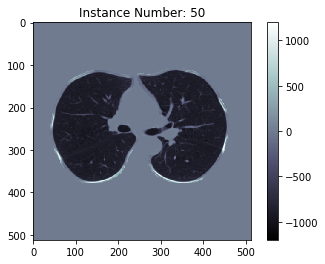

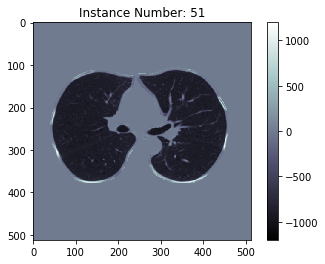

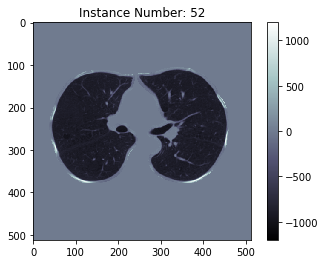

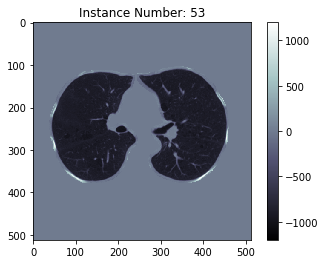

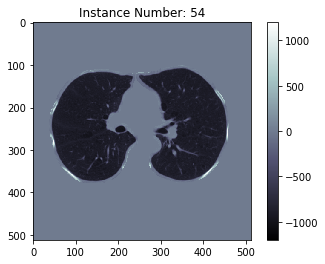

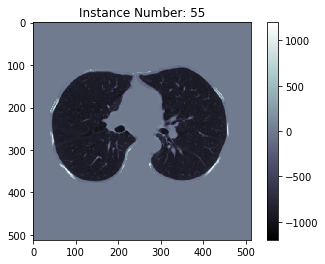

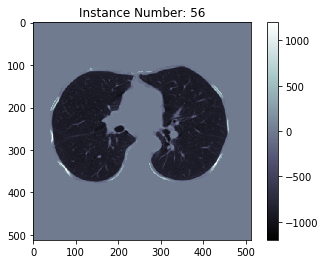

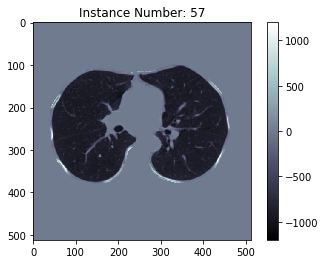

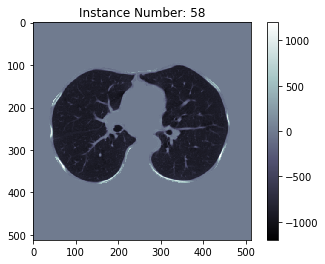

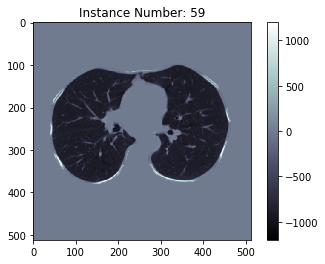

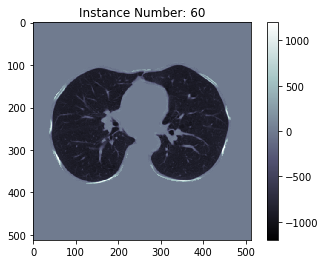

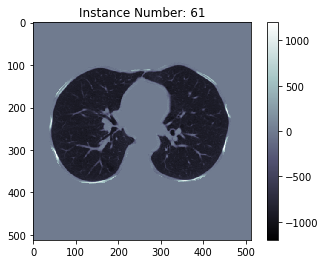

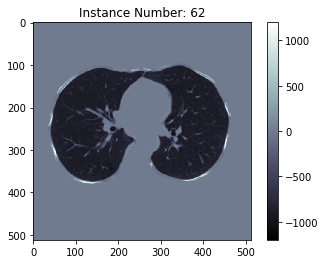

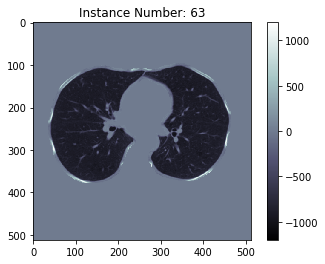

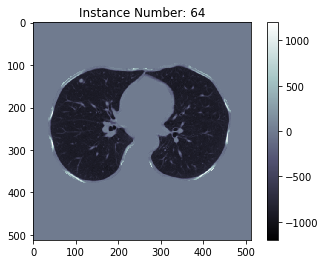

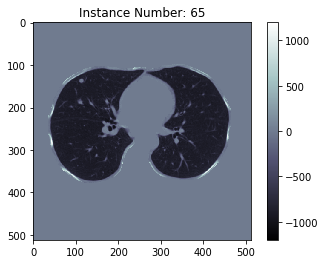

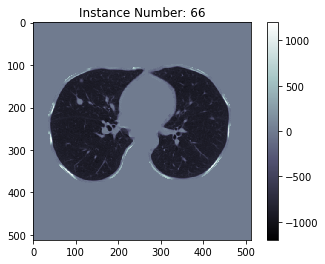

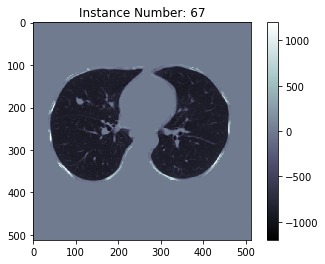

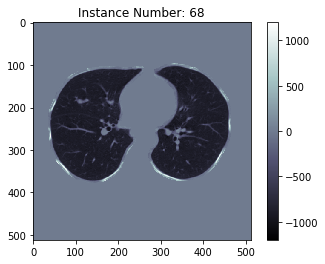

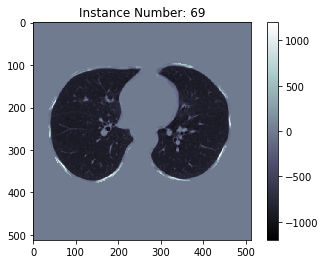

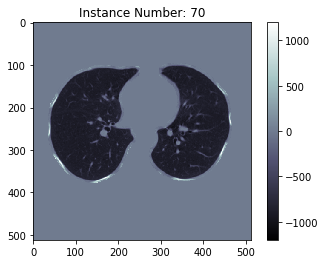

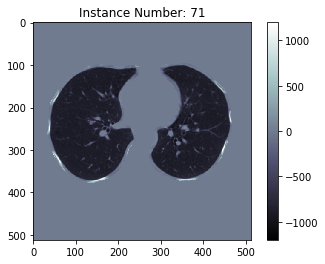

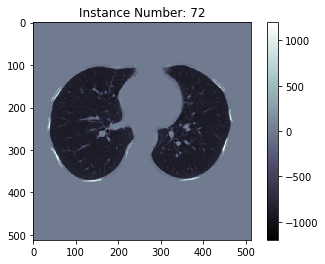

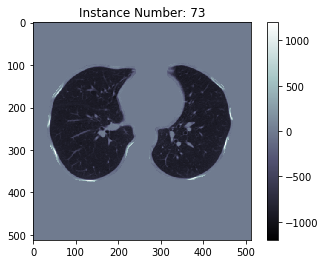

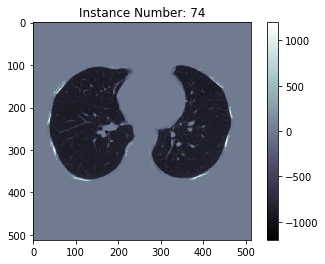

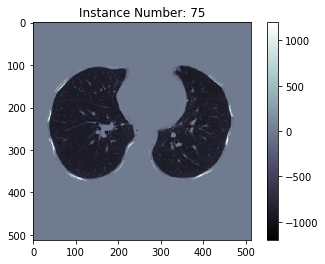

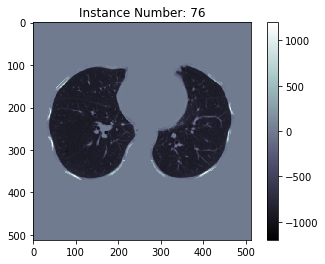

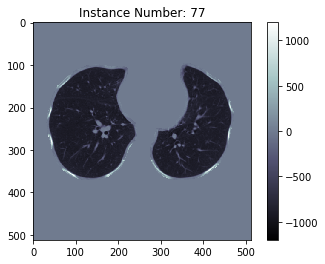

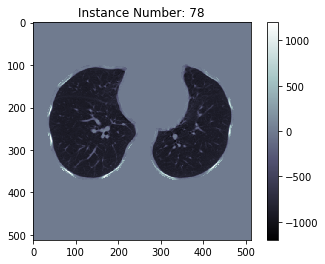

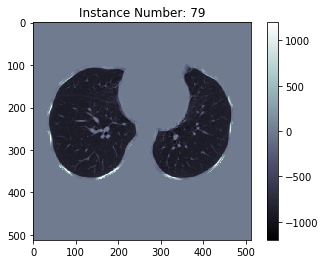

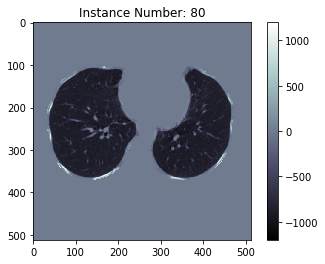

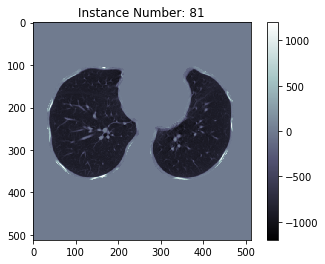

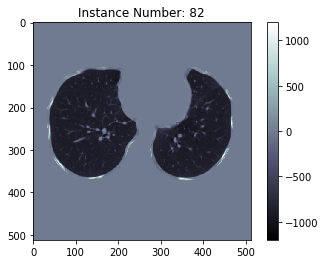

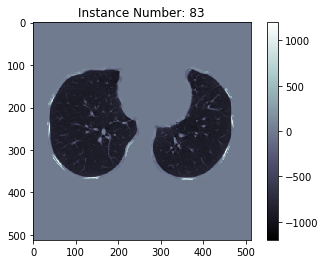

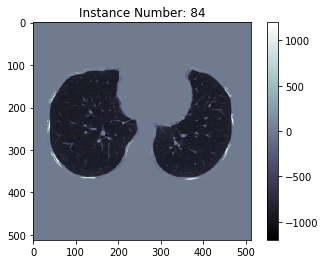

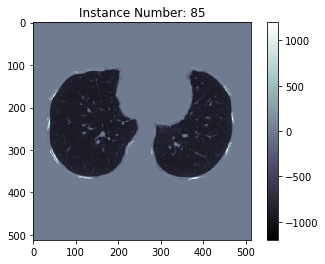

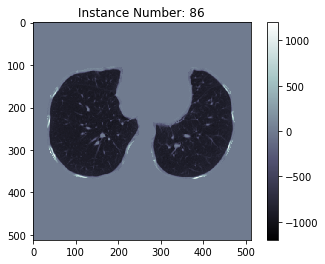

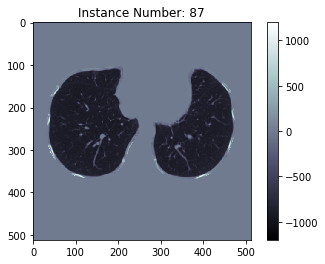

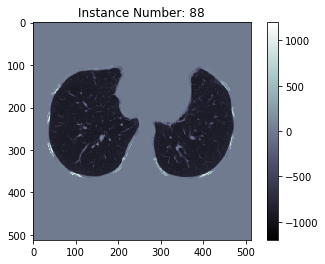

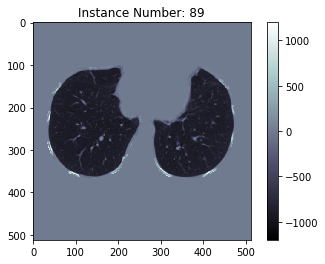

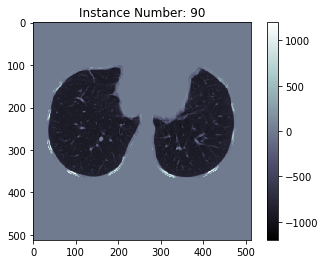

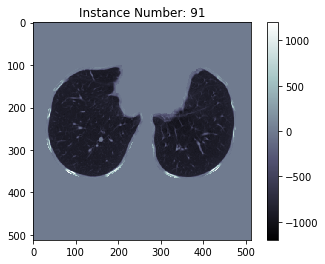

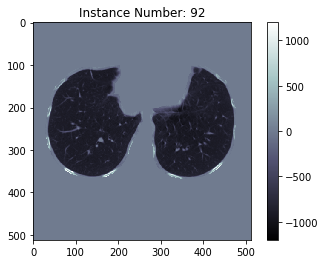

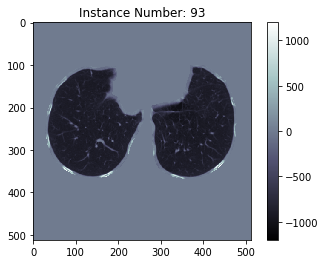

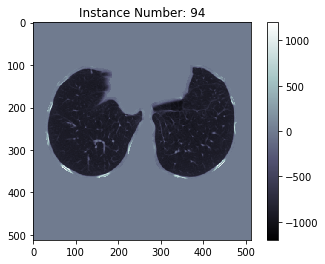

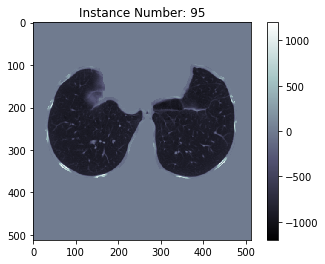

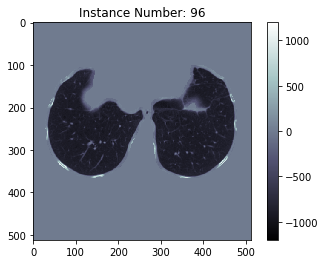

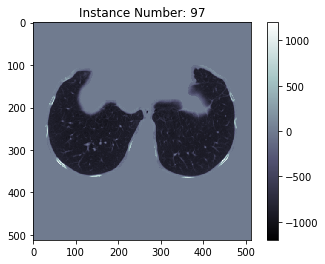

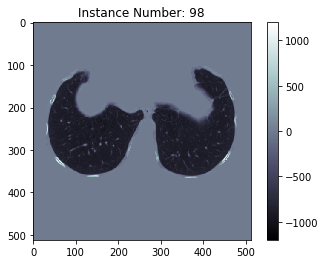

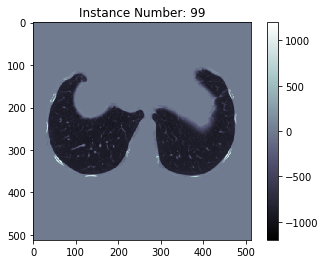

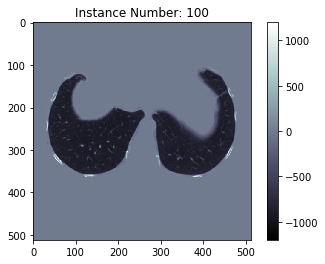

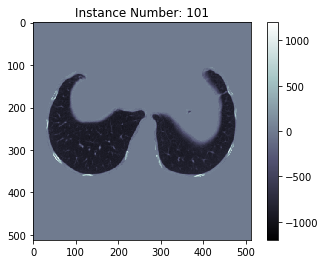

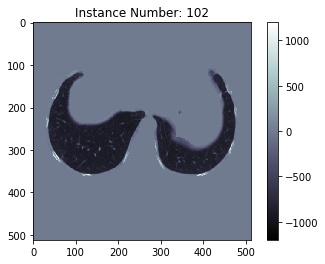

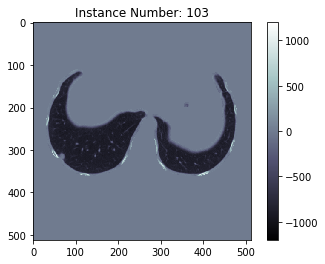

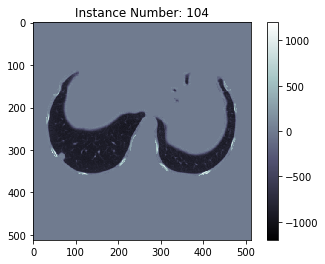

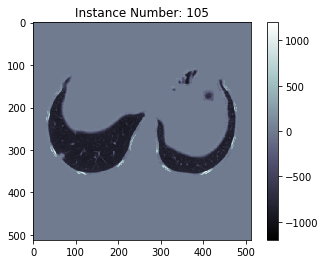

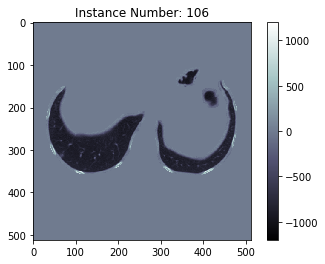

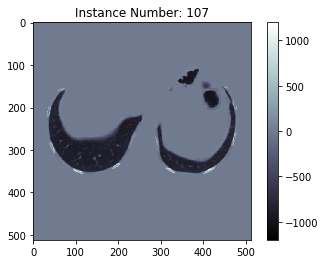

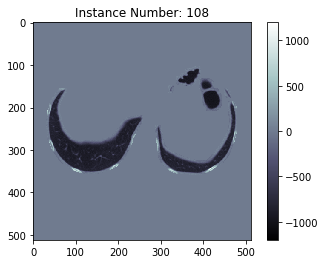

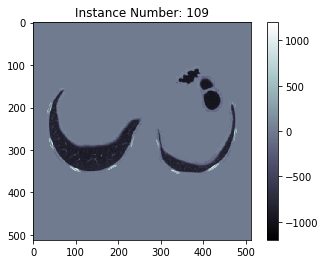

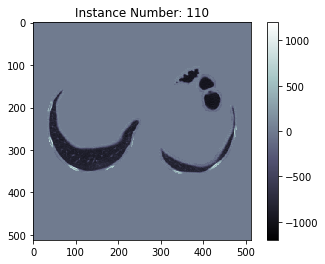

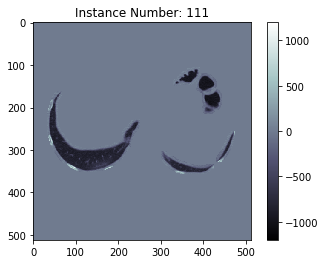

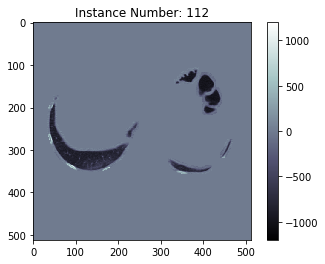

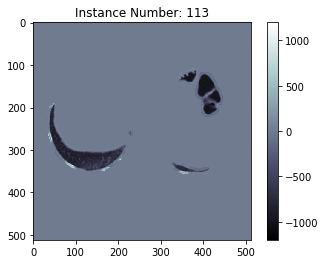

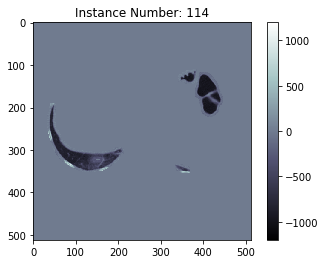

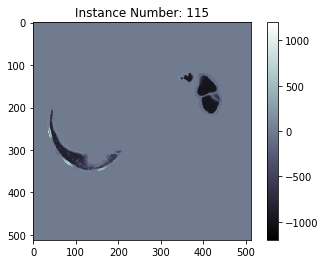

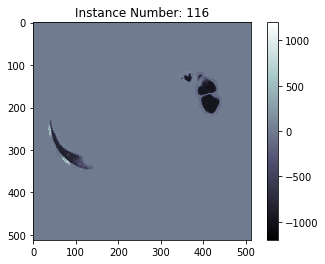

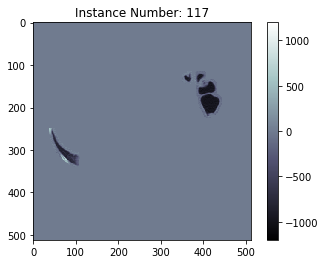

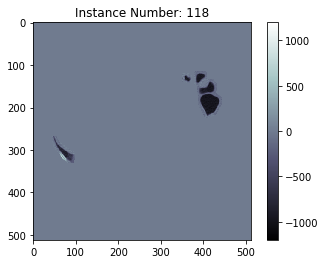

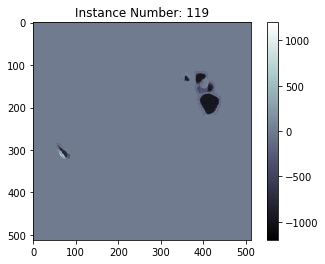

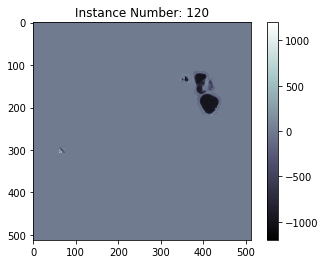

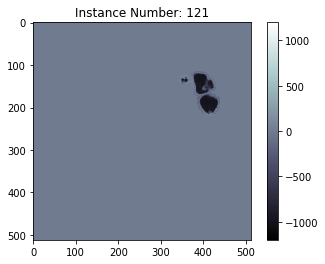

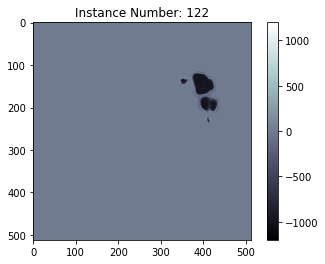

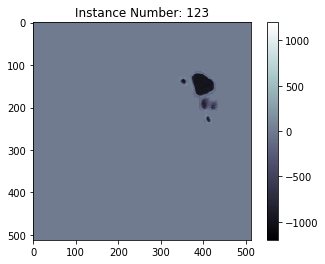

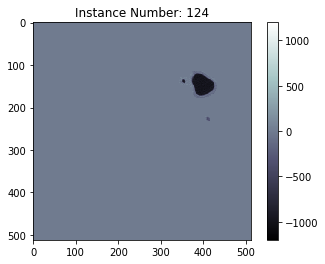

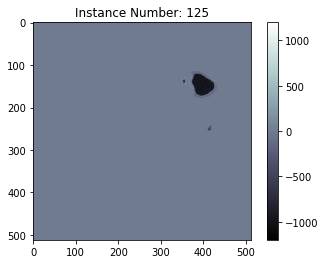

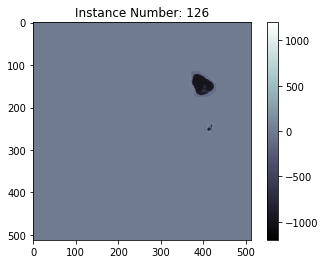

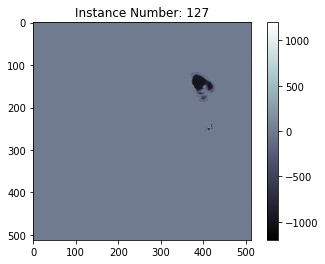

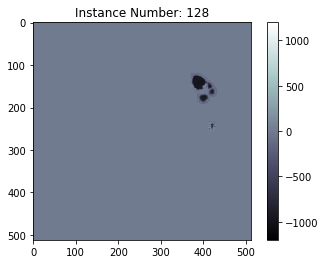

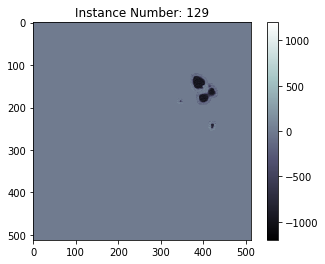

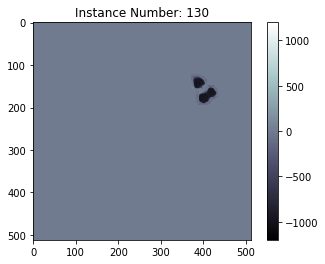

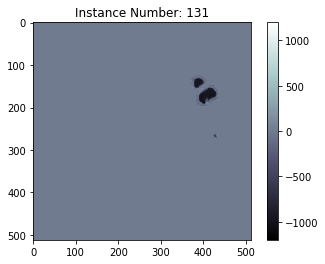

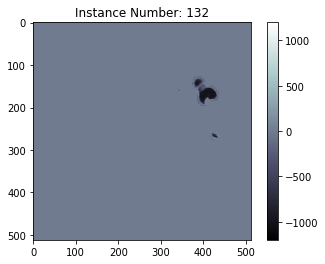

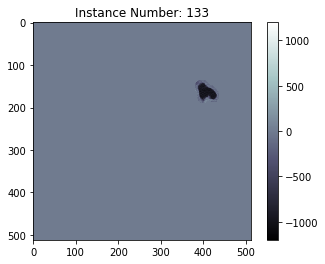

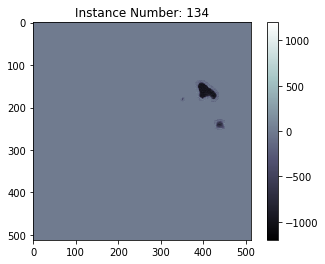

In [38]:
for im in images:
    img = segment_lung(im.pixel_array-1024)
    plt.imshow(img, cmap=plt.cm.bone, clim=(-1200, 1200))
    plt.colorbar()
    plt.title("Instance Number: " + str(im.InstanceNumber))
    plt.show()
    

## Visualize CT Scan
Now that we can separate lung from every slice, it would be a good time to combine them to form a 3D reconstruction of the patient's lung. First, let's stack all the filtered data.

In [23]:
all_pixels = np.stack([segment_lung(im.pixel_array-1024) for im in images])
print(all_pixels.shape)

(134, 512, 512)


As you might imagine, plotting in 3D is more complicated than that in 2D. In particular, how do we convert a $134\times 512\times 512$ numpy array into a 3D entity? We know that lung tissue has around 600 Housefield units. If we observes some region in the 3D array where pixel values change across this value, say, from 400 to 800, then we know that this region probably contains lung tissue, and the position where pixel intensity crosses 600 will likely be the border of the lung. If we take this analysis and apply it globally to the 3D array, we essentially perform a marching cube algorithm to generate a mesh. A nice implementation of such algorithm is provided by `skimage.measure.marching_cubes_lewiner`

Now we can separately visualize 3D structure of bones and lung for this patient

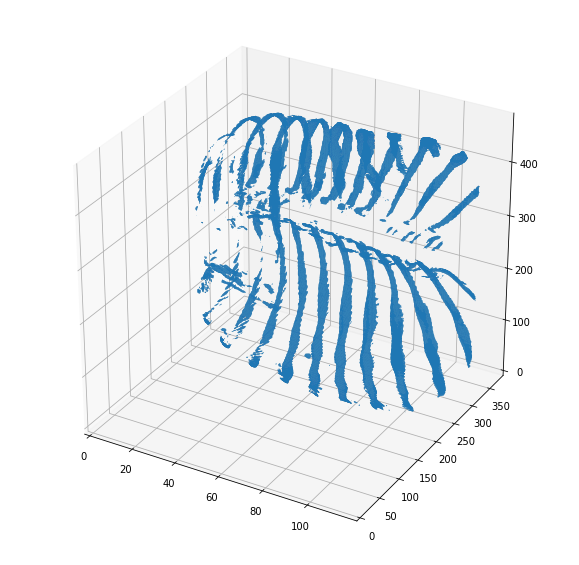

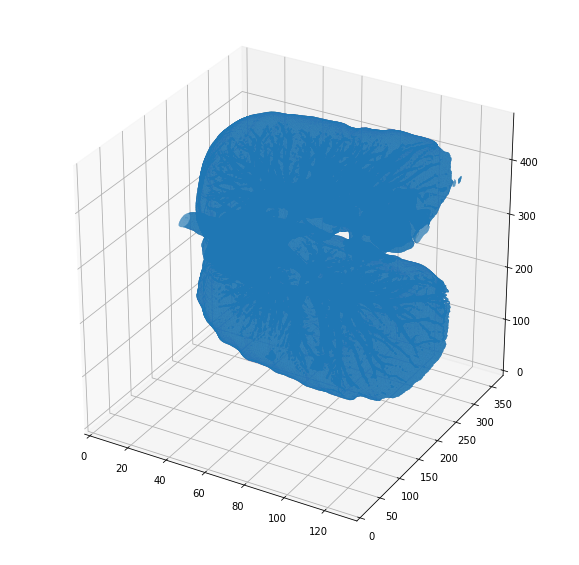

In [40]:
from mpl_toolkits.mplot3d.art3d import Poly3DCollection

LEVEL_BONE = 400
verts, faces, norm, val = measure.marching_cubes_lewiner(all_pixels, level=LEVEL_BONE)
x,y,z = zip(*verts) 
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection='3d')
mesh = Poly3DCollection(verts[faces], alpha=0.3)
ax.add_collection3d(mesh)
ax.set_xlim(0, max(x))
ax.set_ylim(0, max(y))
ax.set_zlim(0, max(z))
plt.show()

verts_interact = verts
faces_interact = faces

LEVEL_LUNG = -600
verts, faces, norm, val = measure.marching_cubes_lewiner(all_pixels, level=LEVEL_LUNG) 
x,y,z = zip(*verts) 
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection='3d')
mesh = Poly3DCollection(verts[faces], alpha=0.3)
ax.add_collection3d(mesh)
ax.set_xlim(0, max(x))
ax.set_ylim(0, max(y))
ax.set_zlim(0, max(z))

plt.show()

## Interactive Visualization
The 3D visualization above is almost perfect, except for interactivity. Since human organs are sophisticated physical objects, we might want to examine the structure from whatever viewpoint we pick. To enable this, we need help of the `ployly` library. More specifically, we utilize the `plotly.figure_factory.create_trisurf` function. https://plot.ly/python/trisurf/

The following snippet will produce a interactive 3D visualization that is about 85M in size. Therefore, I surpressed the output for submission to Autolab, but the code is fully functional.

In [41]:
import plotly
import plotly.figure_factory as FF

plotly.offline.init_notebook_mode(connected=True) 

x,y,z = zip(*verts_interact)
fig = FF.create_trisurf(x=x, y=y, z=z,
                        plot_edges=False,
                         simplices=faces_interact,
                         title="Rotate it!",
                        )
plotly.offline.iplot(fig)

## Label Extraction
Visualizing lungs is pretty cool, but as data scientists or computer vision practitioners, we want to infer more information. For instance, given a CT scan of a patient, can we tell whether he/she has cancer or not? To accomplish this task we need three-dimentional convolutional neural network (3D CNN). A full tutorial on 3D CNN will add way more complexity to this tutorial. 

We know that source data needs to be labeled in order to train a neural network. The labels are presented in the `stage1_labels.csv` file. The file structure is very simple.

In [42]:
import pandas as pd

df = pd.read_csv("stage1_labels.csv")
print(df.head())

                                 id  cancer
0  0015ceb851d7251b8f399e39779d1e7d       1
1  0030a160d58723ff36d73f41b170ec21       0
2  003f41c78e6acfa92430a057ac0b306e       0
3  006b96310a37b36cccb2ab48d10b49a3       1
4  008464bb8521d09a42985dd8add3d0d2       1


Every `id` field corresponds to a patient folder that contains over 100 CT slices, forming a complete CT scan. The `cancer` field tells you whether the patient has cancer or not.

## Advanced Pre-processing: Resampling


In [24]:
print(all_pixels.shape)

(134, 512, 512)


Recall that each slice of `all_pixels` is a 512-pixel by 512-pixel slice. However, pixels across multiple CT machine do not neccessarily correspond to the same spacing in the physical world. Moreover, we do not know how far two slices are away from each other either. Such ambiguity will confuse the CNN since the training data will likely contain data acquired from different machine, each having their own calibrated pixel sizes and slice spacings. Resampling and interpolation is needed to offset such variation. By the end of the day, we want to make sure that every unit cube in `all_pixels` corresponds to 1mm $\times$ 1mm $\times$ 1mm in the physcial world.

In [19]:
print(images[0].PixelSpacing)
print(images[0].ImagePositionPatient)
print(images[1].ImagePositionPatient)

['0.597656', '0.597656']
['-145.500000', '-158.199997', '-23.700001']
['-145.500000', '-158.199997', '-26.200001']


From the above output, we can calculate the spacing in the z-direction, and we also know the pixel spacing on the x-y plane. Therefore, the resampling process is performed by the following snippet.

In [28]:
from scipy.ndimage import zoom

z_spacing = abs(images[0].SliceLocation - images[1].SliceLocation)
spacing = [z_spacing, images[0].PixelSpacing[0], images[0].PixelSpacing[1]]
spacing = np.array(spacing)
zoom_factor = 1 / spacing
print("Before resampling: ", all_pixels.shape)
all_pixels_resample = zoom(all_pixels, zoom_factor)
print("After resampling: ", all_pixels_resample.shape)

Before resampling:  (134, 512, 512)


C:\Users\yaoy2\Anaconda3\envs\tensorflow\lib\site-packages\scipy\ndimage\interpolation.py:616: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)


After resampling:  (54, 857, 857)


Finally, just do a sanity check by visualizing the resampled scan. Notice not too many differences are observed because `matplotlib` automatically perform some rescaling through `set_x/y/zlim` commands. 

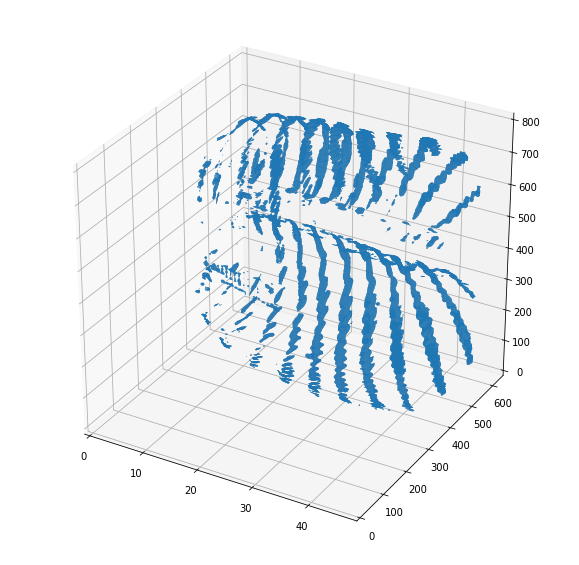